In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

# Benchmarking Partial Data Loading with NPY, NPZ, and HDF5

Many neuroscience experiments generate large data arrays—spike times, imaging data volumes, ephys timeseries, etc.—often gigabytes or terabytes in size. Selecting the right file format (and read strategy) can significantly reduce loading times and memory usage. Here, we compare three popular formats in Python:

- **NPY** (single array in a raw binary format)
- **NPZ** (a ZIP container of NPY files)
- **HDF5** (a hierarchical, chunked container supporting partial reads, often used in large-scale neuroscience)

In this notebook, we'll run measurements checking how long it takes to go from opening a file on disk to having the desired part of a single array in a Python variable.

## Setup

In [2]:
# Steps we plan to test:
actions_list = [
    'Open File',
    'Get Data Variable',
    'Slice All Variable into Memory',
    'Slice Part of Variable into Memory'
]

# Set up a single-run timeit magic that returns a result object
%alias_magic benchmark timeit -p "-r1 -n1 -o" --line

# Generate large random test data
a = np.random.random(size=(1_000_000, 100))
print("Array Shape:", a.shape)
print(f"Array Size in Memory: {a.nbytes / 1024**2 :.1f} MB")

Created `%benchmark` as an alias for `%timeit -r1 -n1 -o`.
Array Shape: (1000000, 100)
Array Size in Memory: 762.9 MB



---



## 2. Benchmark: NPY with `np.load()`

The `np.load()` function is simple with `.npy` files: you call it and immediately get your numpy array into memory!  the downside is, if you only wanted to look at part of the array, you are forced to first read the entire array into memory. 

Here's the code we will test.  Notice that for `np.load()`, some actions have exactly the same code--this will be different for later tests.

| Action                               | Benchmark Code                          |
|--------------------------------------|-----------------------------------------|
| Open File                            | `np.load('a.npy')`           |
| Get Data Variable                    | `np.load('a.npy')`           |
| Slice All Variable into Memory       | `np.load('a.npy')[:]`        |
| Slice Part of Variable into Memory   | `np.load('a.npy')[:10000, 5:20]` |


### Write test file


In [3]:
np.save('a.npy', a)

### Run Benchmark Tests on Reading from Test File

748 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
762 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
631 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
585 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


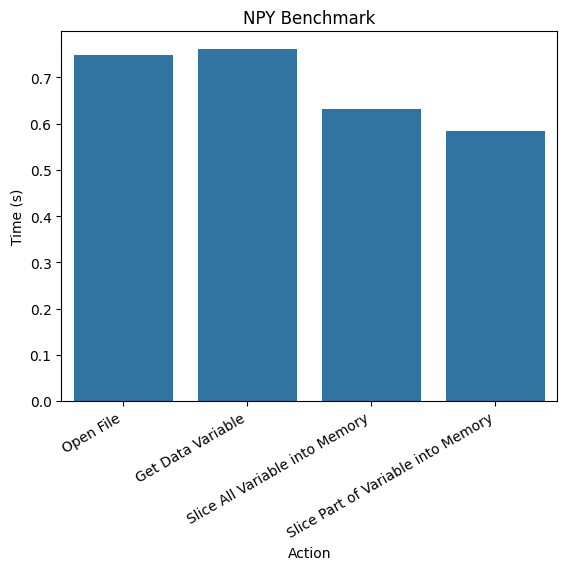

In [4]:

# Time the loading operations
time_npy_openfile  = %benchmark np.load('a.npy')
time_npy_getvar    = %benchmark np.load('a.npy')
time_npy_sliceall  = %benchmark np.load('a.npy')[:]
time_npy_slicepart = %benchmark np.load('a.npy')[:10000, 5:20]

# Collect Times
df_npy = pd.DataFrame({'Action': actions_list, 'Time': [
    time_npy_openfile.average,
    time_npy_getvar.average,
    time_npy_sliceall.average,
    time_npy_slicepart.average
]})

# Plot Results
ax = sns.barplot(data=df_npy, x='Action', y='Time')
ax.set(title='NPY Benchmark', ylabel='Time (s)')
plt.xticks(rotation=30, ha='right');



---



## 3. Benchmark: NPZ

`.npz` files also are read with the `np.load()` function, but they don't immediately read the whole file; instead, they return a collection of the names of variables stored in the file in order to ask you which variables you'd like to load.  This changes the performance of the code, and means that having more datasets in a file doesn't increase the reading time of the file!

Here's the code we will test.  Notice that unlike for `.npy` files, `.npz` files can store many arrays, so you need you to reference the variable name stored in the file for the array you want to load.


| Action                               | Benchmark Code                                 |
|--------------------------------------|------------------------------------------------|
| Open File                            | `np.load('a.npz')`                  |
| Get Data Variable                    | `np.load('a.npz')['a']`             |
| Slice All Variable into Memory       | `np.load('a.npz')['a'][:]`          |
| Slice Part of Variable into Memory   | `np.load('a.npz')['a'][:10000, 5:20]` |



### Write test file

In [5]:
np.savez('a.npz', a=a)

### Run Benchmark Tests on Reading from Test File

35.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


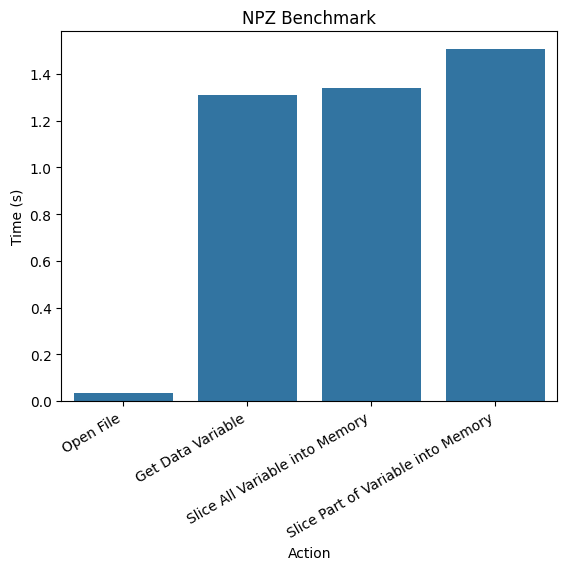

In [6]:

# Time the loading operations
time_npz_openfile  = %benchmark np.load('a.npz')
time_npz_getvar    = %benchmark np.load('a.npz')['a']
time_npz_sliceall  = %benchmark np.load('a.npz')['a'][:]
time_npz_slicepart = %benchmark np.load('a.npz')['a'][:10000, 5:20]

# Collect Times
df_npz = pd.DataFrame({'Action': actions_list, 'Time': [
    time_npz_openfile.average,
    time_npz_getvar.average,
    time_npz_sliceall.average,
    time_npz_slicepart.average
]})

# Plot Results
ax = sns.barplot(data=df_npz, x='Action', y='Time')
ax.set(title='NPZ Benchmark', ylabel='Time (s)')
plt.xticks(rotation=30, ha='right');


---



## Benchmark: HDF5


Below is a reference table for HDF5:

| Action   | Benchmark Code    |
|---------|-------------------------|
| Open File                            | `f = h5py.File('a.h5')`      |
| Get Data Variable                    | `f['a']` |
| Slice All Variable into Memory       | `f['a'][:]`           |
| Slice Part of Variable into Memory   | `f['a'][:10000, 5:20]`  |




### Write test file


In [7]:
with h5py.File('a.h5', 'w') as f:
    f['a'] = a

### Run Benchmark Tests on Reading from Test File

28.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
730 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
883 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.68 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


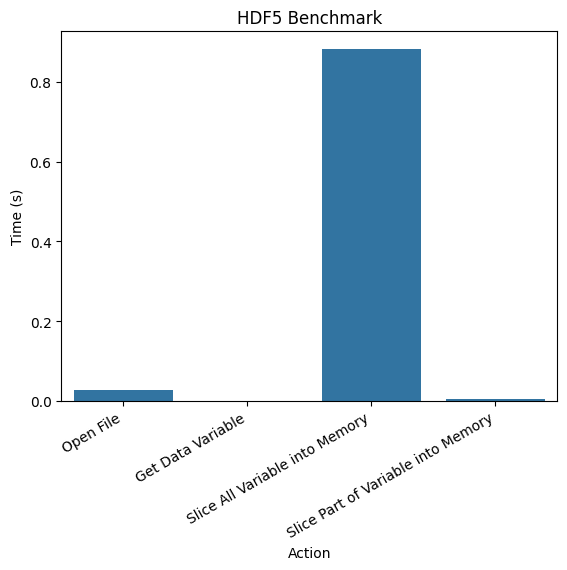

In [8]:
# Time the loading operations
time_h5_openfile = %benchmark h5py.File('a.h5').close()

with h5py.File('a.h5', 'r') as f:
    time_h5_getvar    = %benchmark f['a']
    time_h5_sliceall  = %benchmark f['a'][:]
    time_h5_slicepart = %benchmark f['a'][:10000, 5:20]

# Collect Times
df_h5 = pd.DataFrame({'Action': actions_list, 'Time': [
    time_h5_openfile.average,
    time_h5_getvar.average,
    time_h5_sliceall.average,
    time_h5_slicepart.average
]})


# Plot Results
ax = sns.barplot(data=df_h5, x='Action', y='Time')
ax.set(title='HDF5 Benchmark', ylabel='Time (s)')
plt.xticks(rotation=30, ha='right')
plt.show()



## Combined Comparison

Let's combine the results from all the tests.



In [9]:
df_npy['Format'] = 'NPY'
df_npz['Format'] = 'NPZ'
df_h5['Format'] = 'HDF5'

df_all = pd.concat([df_npy, df_npz, df_h5], ignore_index=True)
df_all


,Action,Time,Format
0,Open File,0.748353,NPY
1,Get Data Variable,0.761522,NPY
2,Slice All Variable into Memory,0.630647,NPY
3,Slice Part of Variable into Memory,0.584903,NPY
4,Open File,0.035766,NPZ
5,Get Data Variable,1.307559,NPZ
6,Slice All Variable into Memory,1.338603,NPZ
7,Slice Part of Variable into Memory,1.506467,NPZ
8,Open File,0.028292,HDF5
9,Get Data Variable,0.000730,HDF5


...and plot the results!

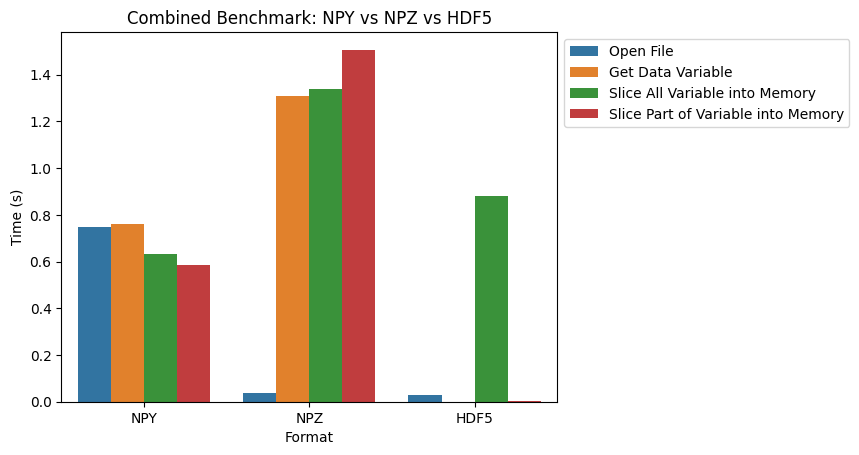

In [10]:
ax = sns.barplot(data=df_all, x='Format', y='Time', hue='Action')
ax.set(ylabel='Time (s)', title='Combined Benchmark: NPY vs NPZ vs HDF5')
ax.legend(bbox_to_anchor=(1, 1));


## Discussion

- **NPY**: Best for storing single arrays, quick to load everything at once. If your dataset is not massive, or you always need the entire array in memory, NPY can be sufficient and easy.  
- **NPZ**: Can store multiple arrays in one container. Great for distributing small to moderate collections of arrays, but it often unzips and loads large data fully, so partial reads aren’t a big advantage here.  
- **HDF5**: Highly recommended for large-scale neuroscience data (e.g., multi-gigabyte or terabyte-level recordings in ephys, calcium imaging movies, etc.). With h5py, you can:
  - Store multiple named datasets in a single file, mimicking a file system hierarchy (`f['my_neuron_data']`, `f['stimulus']`, etc.).
  - Load only the specific slices or channels you need (saves memory and speeds up analysis for partial reads).
  - Potentially use chunking and compression options to optimize read performance for your specific use-case.

In real-world neuroscientific workflows—where data can be huge (e.g., weeks-long continuous recordings, thousands of channels, volumetric imaging stacks)—HDF5’s partial reading avoids the memory overload and time cost of reading massive arrays you don’t fully need.

When choosing a file format for large data arrays in neuroscience, **HDF5** stands out by offering partial loading, chunking, and hierarchical organization. Although opening an HDF5 file has some initial overhead, it pays off if you only need to read part of a large dataset repeatedly.